In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf

etfs = {
    "IWDA.L": "market",
    "IVLU": "value",
    "IWSZ.L": "size",
    "IMTM": "momentum",
    "IWQU.L": "quality",
    "ICLN": "clean_energy",
}

symbols = list(etfs.keys())

prices_daily = (yf.download(
    tickers=symbols, 
    progress=True
  )
  .dropna()
  )

returns_daily = (prices_daily
  .stack()
  .reset_index(level=1, drop=False)
  .reset_index()
  .rename(columns={
    "Date": "date",
    "Adj Close": "adjusted"}
  )
  # transform the Ticker column into a name column, using the etfs dictionary
  .assign(name = lambda x: x["Ticker"].map(etfs),
          ret=lambda x: x.groupby("name")["adjusted"].pct_change())
    .get(["name", "date", "ret"])
    .dropna()
)


(returns_daily
  .groupby("name")["ret"]
  .describe()
  .round(3)
)

[*********************100%%**********************]  6 of 6 completed


Price          name       date       ret
6      clean_energy 2015-07-16  0.021375
7          momentum 2015-07-16  0.000000
8             value 2015-07-16  0.000000
9            market 2015-07-16  0.005068
10          quality 2015-07-16  0.004037
...             ...        ...       ...
13825      momentum 2024-11-08 -0.008651
13826         value 2024-11-08 -0.017409
13827        market 2024-11-08  0.000273
13828       quality 2024-11-08  0.002103
13829          size 2024-11-08 -0.000743

[13824 rows x 3 columns]


,count,mean,std,min,25%,50%,75%,max
name,,,,,,,,
clean_energy,2304.0,0.0,0.017,-0.128,-0.008,0.000,0.009,0.114
market,2304.0,0.0,0.010,-0.106,-0.004,0.001,0.005,0.085
momentum,2304.0,0.0,0.011,-0.107,-0.005,0.000,0.006,0.077
quality,2304.0,0.0,0.010,-0.092,-0.004,0.001,0.005,0.082
size,2304.0,0.0,0.011,-0.115,-0.005,0.001,0.006,0.087
value,2304.0,0.0,0.012,-0.117,-0.005,0.000,0.006,0.090


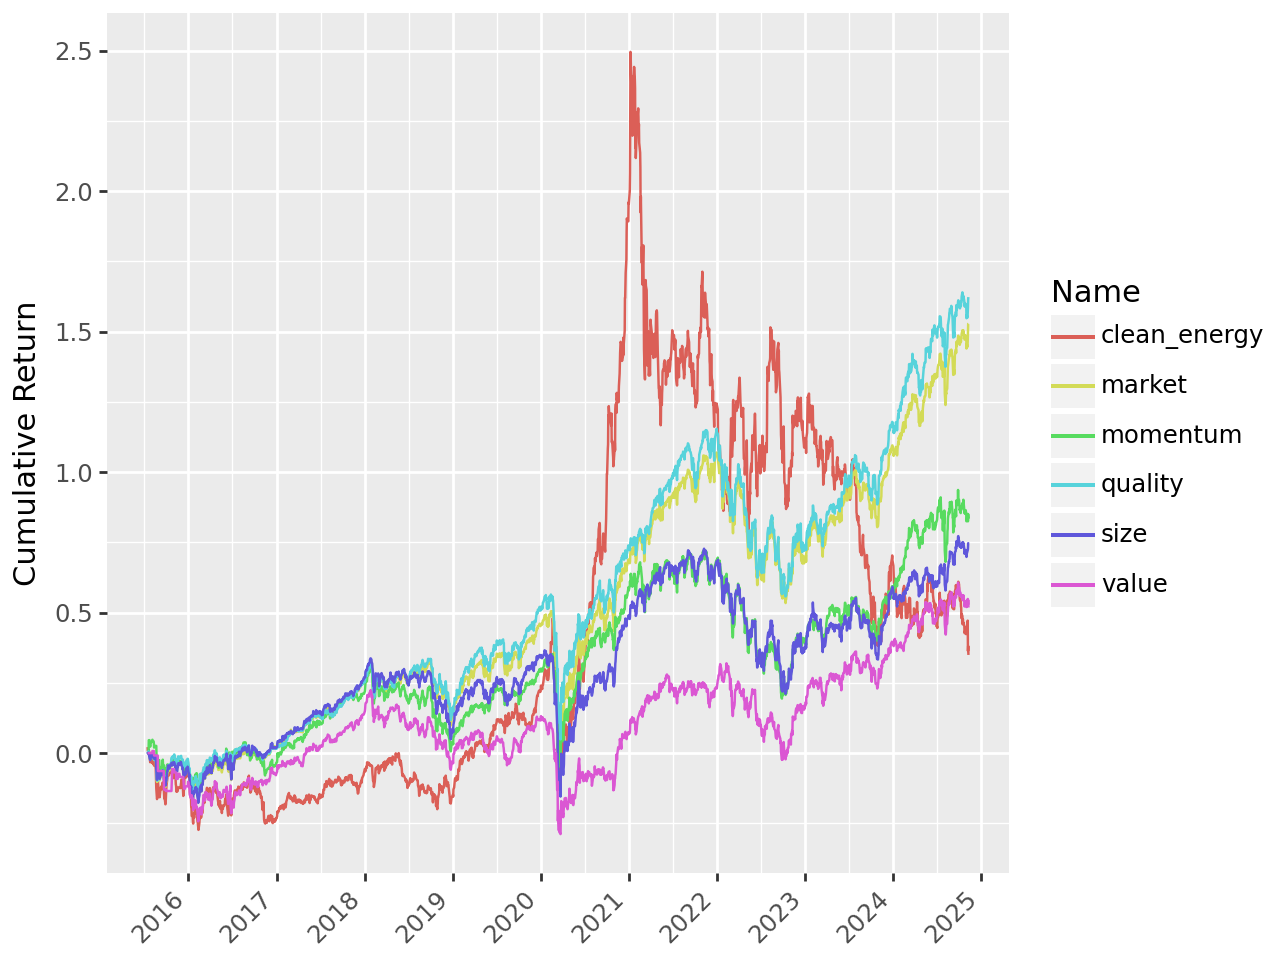

In [22]:
from plotnine import *
from mizani.formatters import date_format
from mizani.breaks import date_breaks

# Compute active returns as the difference between the ETF returns and the market returns
active_returns = (
    returns_daily
    .merge(
        returns_daily.query('name == "market"')[["date", "ret"]],
        on="date",
        suffixes=("", "_market"),
    )
    .assign(active_ret=lambda x: x["ret"] - x["ret_market"])
    .drop(columns=["ret_market"])
)

# plot cumulative returns
cum_returns = (
    active_returns
    .get(["date", "name", "ret"])
    .pivot(index="date", columns="name", values="ret")
    .dropna()
    .apply(lambda x: (1 + x).cumprod() - 1)
    .reset_index()
    .melt(id_vars="date", var_name="name", value_name="cum_ret")
)

plot_cum_ret = (
    ggplot(cum_returns, aes(x="date", y="cum_ret", color="name"))
    + geom_line()
    + scale_x_datetime(breaks=date_breaks("1 year"), labels=date_format("%Y"))
    + labs(
        x="",
        y="Cumulative Return",
        title="",
        color="Name",
    )
    + theme(axis_text_x=element_text(angle=45, hjust=1))
)

plot_cum_ret.show()

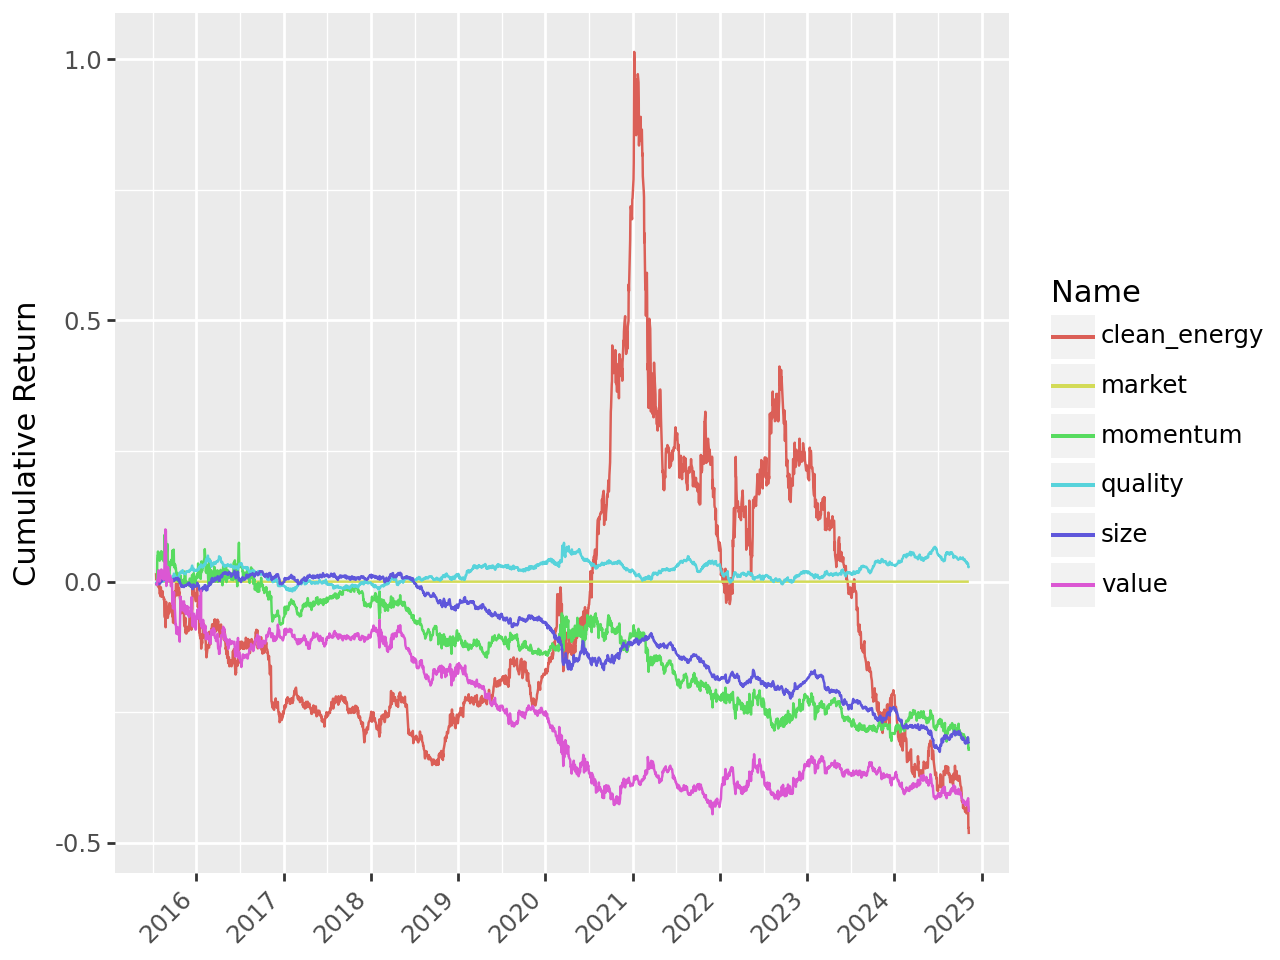

In [23]:
# plot cumulative returns
cum_returns = (
    active_returns
    .get(["date", "name", "active_ret"])
    .pivot(index="date", columns="name", values="active_ret")
    .dropna()
    .apply(lambda x: (1 + x).cumprod() - 1)
    .reset_index()
    .melt(id_vars="date", var_name="name", value_name="cum_ret")
)

plot_cum_ret = (
    ggplot(cum_returns, aes(x="date", y="cum_ret", color="name"))
    + geom_line()
    + scale_x_datetime(breaks=date_breaks("1 year"), labels=date_format("%Y"))
    + labs(
        x="",
        y="Cumulative Return",
        title="",
        color="Name",
    )
    + theme(axis_text_x=element_text(angle=45, hjust=1))
)

plot_cum_ret.show()

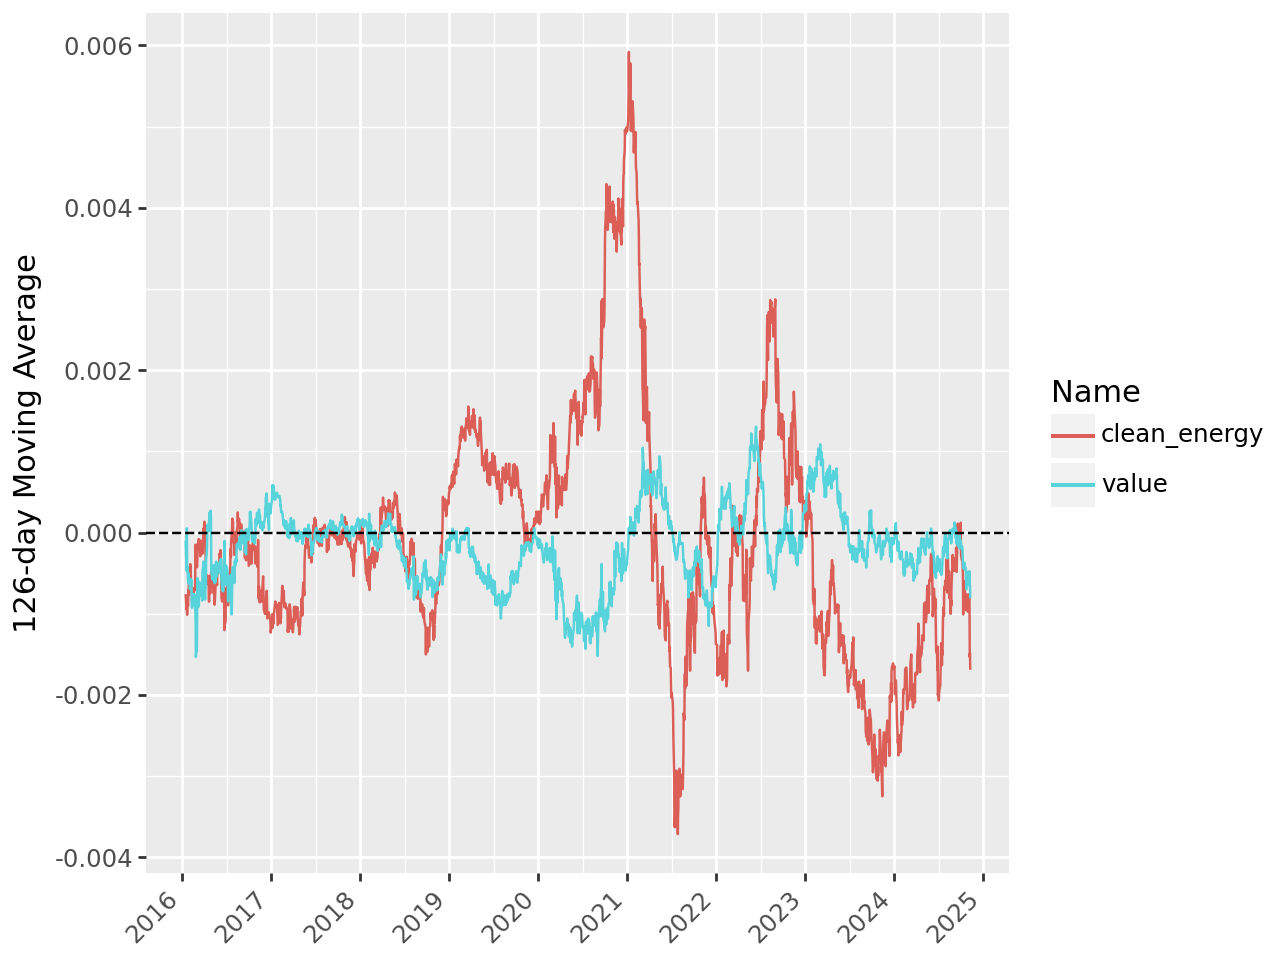

In [30]:
# 126 day moving average

# Compute the 126-day moving average of the active returns
active_returns_ma = (
    active_returns
    .assign(
        active_ret_ma=lambda x: x.groupby("name")["active_ret"].transform(
            lambda x: x.rolling(window=126).mean()
        )
    )
    .dropna(subset=["active_ret_ma"])
)

# plot the the moving average, add a horizontal line at 0
list_to_plot = ["clean_energy","value"]
plot_ma = (
    ggplot(active_returns_ma.query("name in @list_to_plot"), aes(x="date", y="active_ret_ma", color="name"))
    + geom_line()
    + geom_hline(yintercept=0, linetype="dashed")
    + scale_x_datetime(breaks=date_breaks("1 year"), labels=date_format("%Y"))
    + labs(
        x="",
        y="126-day Moving Average",
        title="",
        color="Name",
    )
    + theme(axis_text_x=element_text(angle=45, hjust=1))
)

plot_ma.show()
